Copyright (c) 2023, University of Cambridge, all rights reserved. Written by Andrew Wheeler, University of Cambridge



# Desktop DNS Notebook 1: Getting started

---
### User agreement and correct use of these tools
This notebook and associated Python code are provided for non-commericial/academic use only. For those interested in commercial application of these tools please contact Andrew Wheeler (e-mail: aw329@cam.ac.uk). Please read the license agreement (LICENSE.txt).


If you use these tools for a publication please include the citation:

*Wheeler A.P.S. (2023) 'Desktop-DNS: An open toolkit for turbomachinery aerodynamics', ASME Turbo Expo 2023, ASME Paper no. GT2023-1023647*


---

## 1.0 Introduction

The principle behind direct numerical simulation (DNS) is to directly simulate the unsteady Navier-Stokes equations without resorting to turbulence models, by capturing all the turbulent scales in the flow. The aim is to remove the uncertainty associated with modelling turbulence and transition phenomena. Because the Navier-Stokes equations are an almost perfect representation of fluid flows found in turbomachinery components, DNS can be thought of as a virtual experiment. Using DNS we can capture flow details which would be extremely challenging to measure in a physical experiment (such as dissipation or entropy generation rate). However the computational costs can be significant, particularly when Reynolds numbers are high, or the geometry is very complex. This toolkit allows you to explore DNS, providing the full work-flow - from meshing, running and post-processing the results. 

These notebooks will guide you through the process of running and analysing a DNS of a compressor-blade cascade. We will use *3DNS-gpu*, which is a high-order DNS solver suitable for turbomachinery and internal flows. These notebooks will provide a step-by-step guide on running *3DNS-gpu*, as well as guiding you through the pre-processing and post-processing tools (written in Python) associated with setting-up and analyzing the simulations.

The notebooks accompany the paper:
*Wheeler A.P.S. (2023) 'Desktop-DNS: An open toolkit for turbomachinery aerodynamics', ASME Turbo Expo 2023, ASME Paper no. GT2023-1023647*

Please read this paper before starting. The flow conditions for the test-case described in these notebooks have been adjusted in order to reduce the Reynolds number compared to the paper, and therefore the computational costs, as shown in the table below. This is done by scaling the molecular viscosity and thus does not affect the Mach number.

|| $$Re_{cax}$$            | $$M_{in}$$ | $$\alpha_{in}$$ | 
|-|-------------------|----------|---------------|
| GT2023-1023647 | $233 \times 10^3$ | $0.2$ | $50.2^o$ |
| Notebooks | $74.6 \times 10^3$ | $0.2$ | $50.2^o$ |


The *3DNS-gpu* user guide (found in the repository 'Releases') also gives more detail on the code including the format for the input and output files and running of the code - it is useful to familiarize yourself with this before running the simulations.

You can run these notebooks on an ordinary PC or laptop with Python 3 and Jupyter installed. The notebooks work best with Linux operating systems, and the guidance below assumes you are using a Linux OS. If you are using Microsoft Windows 11, consider installing a Linux environment that runs within Windows (such as Kali Linux). Some basic understanding of Python and using a Linux command-line interface is assumed. 

A description of the Python routines used in these notebooks is given in the 'tools.ipynb' notebook. This lists the inputs and outputs for each of the main functions used.


In order to run the simulations you'll need access to a computer with an NVIDIA GPU - guidance on accessing an appropriate machine using Amazon Cloud Services is described later. The simulation output files can then be copied to your local machine so that the data is accessible to these notebooks.

In this notebook, you will learn how to: 
* set-up an initial mesh and case files;
* establish an initial flow
* run a case in 2D;
* view the flow files

In order to progress through the notebook, run each cell in turn by pressing the 'Run' button in the top toolbar. The highlighted cell will automatically move to the next cell, but ensure that the previous cell has completed before continuing. To re-run a cell, simply select the cell and press 'Run' again. A cell which is still running will be indicated by an asterisk on the left-hand side of the cell like this - 'In [*]'. 

## 1.1 Read in the profile
First we read-in the blade profile. The format for the profile file is:

number of points\
pitch\
x y

The example used here is for the AS2375 compressor blade cascade, designed and created by Alistair Senior (Whittle Laboratory, University of Cambridge).


In the read_profile() function below, the coordinates are shifted so that the leading-edge is the origin, and scaled so that the axial chord is 1. It is good practise to normalize the geometry in this way. When setting the geometry, it is then relatively easy to set the computational mesh and topology set-up based on the axial chord.


In [1]:
# this cell ensures that python modules are reloaded at runtime

%reload_ext autoreload
%autoreload 2


<function matplotlib.pyplot.show(close=None, block=None)>

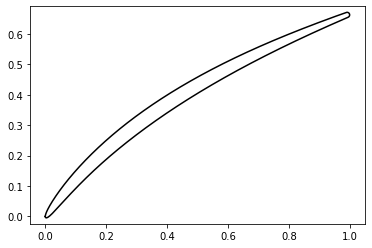

In [2]:
import matplotlib.pyplot as plt
from meshing.read_profile   import *

# pop-out figures
#%matplotlib qt

# in-line figures
%matplotlib inline

# read in profile and normalize so that Cax=1.0 (normalization set to 'True')
xprof,yprof,pitch,stag=read_profile('geom/profile.txt',True)

# plot the profile to check
plt.figure(1)
plt.plot(xprof,yprof,'-k')
plt.axis('equal')
plt.show

When reading-in your own profile, you should check that the profile is well defined- are there sufficient points? is the surface curvature smooth? Check regions such as the trailing-edge and leading edge, and plot the curvature. 

This is particularly important for high-order finite difference schemes, where surface and mesh quality are very important.

In some cases you may need to re-generate the profile to ensure smoothness. 

***

## 1.2 Generate the topology and mesh

We first create a coarse mesh, defining the multi-block topology. A Poisson solver is used to create a smooth multi-block mesh. It is much better to solve for the block boundaries using a very coarse mesh, and then refine this mesh, rather than solving for the block boundaries on a fine mesh.

This may take a few minutes. Wait for the cell to complete before moving to the next cell.

Now we can refine the mesh to create a baseline mesh for our initial simulations.

This may take a few minutes, depending on the level of refinement and smoothing iterations.

* It is best to start off with a relatively coarse mesh, even at this stage, when getting a new case established- so don't be too keen to ramp up the refinement factor at this point.

* Once you've got a coarse simulation running, it is relatively straight forward to interpolate this solution onto a finer a mesh and continue running. 

* Running a baseline case on a coarse mesh is useful because a lot of compute cost can be wasted in getting through transients and establishing a steady-state flow.


Now we're ready to create case files for the 3DNS solver with the baseline mesh. 

* These set-up a 2D case. We will start with a 2D case. Later we will extrude the solution in the spanwise direction to run a 3D case once we have a 2D flow established. This reduces the compute cost of the initial transient. 

* We'll set-up a case running at low Reynolds number, by running with an increased viscosity. Again, this helps us to run on a coarse mesh so that we can race through the pressure transients.

* The solver uses characteristic boundary conditions, which determine the rates of change of the flow properties at the inlet and exit. The way these are implemented is to fix the inlet entropy and inlet velocity. This means that the inlet stagnation conditions are only weakly imposed- the values inputted in the input file below set an initial state. 

* Later you can check what the stagnation conditions at inlet converge to once the flow has reached a statistically converged state. 

* When setting your boundary conditions below, make sure that the inlet velocity is compatible with the pressure ratio chosen- otherwise you can set-up a horrendous transient which will take a long time to settle down.




In [3]:
# inilitialize dictionaries
mesh   = {}

# case name and profile coordinates
casename = 'notebook1'
mesh['case'] = casename
mesh['profile'] = 'geom/profile.txt'

# initial mesh inputs
mesh['npp'] = 2*[None]
mesh['ywall'] = 2*[None]
mesh['msmooths'] = 2*[None]

mesh['npp'][0] = 4
mesh['Lup'] = 1.0
mesh['Ldn'] = 1.0
mesh['Lo'] = 0.2
mesh['ywall'][0] = 0.04/150
mesh['msmooths'][0] = 500
mesh['cor_fac'] = 0.75 # factor shrinking multi-block corner cells - lower values give more shrinkage.

# final mesh inputs
mesh['npp'][1] = 28
mesh['refine_fac'] = 2 
mesh['ywall'][1] =  0.02/150 
mesh['msmooths'][1] = 200

# scale factor if used (set to 1.0 if not)
mesh['scale_factor'] = 1.0

# flip y coordinates if -1 (1 for no flip)
mesh['flip'] = 1



The function blade_mesher() below uses an iterative Poisson solver to determine the mesh points. This can take some time. Don't move on to the next cell until the cell has completed.

In [4]:
from meshing.blade_mesher import *
import timeit

start = timeit.default_timer()

# create mesh 
case = blade_mesher(mesh)

stop = timeit.default_timer()

print('Time: ', stop - start)  



Time:  132.0133837708272



The next cell plots the mesh. Check that you're happy with the mesh - particularly in regions of high curvature like the leading and trailing edges. Use the zoom functions on the pop-out figure to check the mesh.


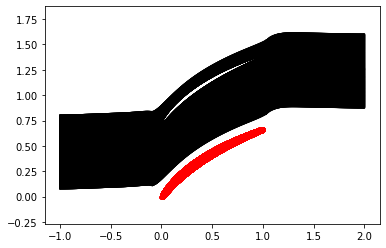

In [19]:
import matplotlib.pyplot as plt

# pop-out figures
%matplotlib qt

#%matplotlib inline


# unpack case for plotting
blk = case['blk']

# plot profile, topology and mesh
plt.figure(1)
plt.plot(xprof,yprof,'-r.')
plt.axis('equal')

for ib in range(len(blk)):
    xnew=blk[ib]['x']
    ynew=blk[ib]['y']
    plt.plot(xnew,ynew + pitch,'k')
    plt.plot(np.transpose(xnew),np.transpose(ynew) + pitch,'k')

plt.show()



In [6]:

# initialize dictionaries
bcs    = {}
gas    = {}
solver = {}

# solver inputs [SI-units]

# boundary conditions
bcs['Toin'] = 300.0 #K, initial guess of inlet total temp.
bcs['Poin'] = 100000.0 #Pa, initial guess of inlet total p.
bcs['pexit'] = 98361.0 #Pa, exit static p. 
bcs['vin'] = 70.0 #m/s, inlet velocity
bcs['alpha'] =  50.23 #degrees, inlet yaw angle  
bcs['gamma'] = 0.0 #degrees, inlet pitch angle
bcs['aturb'] = 0.0 # amplification factor for turbulence
bcs['lturb'] = 0 # not used
bcs['ilength'] = 500 # inlet turbulence generation frequency (no. steps)
bcs['radprof'] = 0 # impose spanwise profile when = 1.
bcs['twall'] = -1.0 # not used
bcs['cax'] = 1.0 # not used


# gas properties
gas['gamma']=1.4   # adiabatic exponent
gas['cp'] = 1005.0 # J/kg/K
gas['mu_ref'] = 1.0e-3 # scale ref. viscosity to match Re
gas['mu_tref'] = 273.0 # Sutherland's Tref
gas['mu_cref'] = 110.4 # Sutherland's Cref
gas['pr'] = 0.72 # Prandtl number


# solver inputs
solver['niter'] = 200000
solver['nwrite'] = 1000
solver['ncut'] = 10000000 # write cut file frequency    
solver['cfl'] = 1.0
solver['sigma'] = 0.05 # filter coefficient
    
solver['irestart'] = 0 # no re-start
solver['span'] = 0.2 # spanwise extent for 3D calcs - typically 10-20% of chord
solver['fexpan'] = 1.0 # must be 1.0

solver['nk'] = 1 # spanwise points for 3D calculation 
solver['npp'] = 1 # not used for gpu version
solver['istats'] = 0 # 0=no time averaging, 1=3D time average, 2=2D time average
solver['version'] = 'gpu' # write inputs for gpu version of the solver
                
# define block groups for each GPU card
block_groups = 1*[None] # 1 block group 
# blocks in each block group
block_groups[0] = {}
block_groups[0]['blocks'] = [1,2,3,4,5,6,7,8,9]
solver['block_groups'] = block_groups
solver['nkproc'] = 1 # GPUs in spanwise direction

# pack-up case
case['bcs'] = bcs
case['gas'] = gas
case['solver'] = solver

total_GPUs = solver['nkproc']*len(block_groups) # total number of GPUs
        
    
    


In [223]:
from meshing.write_case import *

# write 3DNS case files
write_case(case)




Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1



A new directory will have been created in your working directory called 'notebook1' containing all the files for running the simulation.

Use the command-line command in your working directory to view the files
> ls notebook1/

You should see the grid files ('grid_#.txt') and input file ('input_gpu.txt'). There will be 9 grid files - 1 per block. The input file contains the connectivity of the blocks, boundary conditions, gas properties and other solver-setup details. 

Further information on the input file can be found in the *3DNS-gpu* userguide which you can download along with the *3DNS-gpu* software (instructions about this are described later).

These are all the files necessary for running *3DNS-gpu*, but we can reduce the time to reach convergence by providing an initial guess of the flow, which is done next.

---

## 1.3 Create an initial guess


### Create initial guess using streamline curvature method

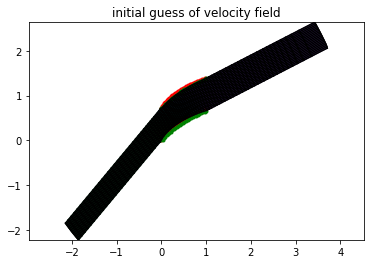

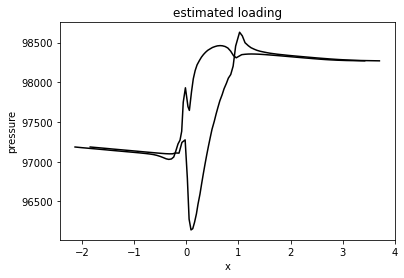

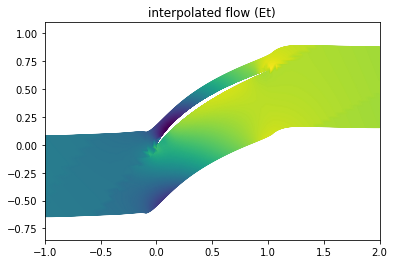

In [7]:

from meshing.initial_guess import *
from meshing.write_flo import *

casename = 'notebook1'

# create initial guess (last two integers define the streamline curvature grid dims)
# adjust total pressure with assumed loss coefficient
Yp = 0.103
prop = initial_guess(mesh,blk,bcs,gas,30,20,Yp)

# write initial flow files
write_flo(prop,casename)



If you now look in the 'notebook1' directory you'll see a new set of 'flow_#' files - one for each of the 9 blocks.



### Check initial flow and exit pressure. Update case files

In [225]:
import matplotlib.pyplot as plt

from meshing.read_case import *
from meshing.write_case import *
from postpro.read_flo import *
from postpro.plot_flo import *

# read casefiles
case = read_case(casename)

# read initial flow and compute derived quantities
prop,geom = read_flo(casename)

# adjust exit pressure according to initial guess pexit 
pexit = np.mean(prop[8]['p'][:,:,-1])

# inlet conditions
roin = np.mean(prop[0]['ro'][1,:,-1])

print('initial guess for Pexit = ', pexit, 'Pa')
print('Pexit in old case file = ',case['bcs']['pexit'],'Pa')

case['bcs']['pexit'] = np.floor(pexit)
print('updating pexit to ', case['bcs']['pexit'], 'Pa')

# set restart flag to restart from initial flow
case['solver']['irestart'] = 1 # 

# write new case files
write_case(case)

# plot flow
plot_flo(prop,geom,'mach',[0.0,0.3])
    


gpu input file found
2
gpu input file found
2
initial guess for Pexit =  98361.16350280386 Pa
Pexit in old case file =  98361.0 Pa
updating pexit to  98361.0 Pa
Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

---

## 1.4 Running a preliminary 'steady' simulation

In this part we'll use a simple RANS model to establish a steady solution for the flow. This will give a starting point for the unsteady simulations and also help us assess the mesh resolution.

In [226]:
from meshing.write_rans import *

casename = 'notebook1'

rans = {}

rans['if_rans'] = 1
rans['speed_up'] = 3.0

write_rans(casename,rans)



### Running *3DNS-gpu* using Amazon Cloud Services

In order to run *3DNS-gpu* you'll need access to a computer with an appropriate NVIDIA GPU. 

The guidance below describes how to start using *3DNS-gpu* using Amazon Cloud Computing. If you don't want to use AWS see the Appendix below for other options.

First create an AWS account https://aws.amazon.com/?nc2=h_lg . Once you're set-up:

* Go to your EC2 Dashboard and choose your region from the toolbar on the top right (note that costs can vary significantly between regions, so check carefully the costs).

* Select 'Launch instance' and search for NVIDIA HPC SDK GPU-Optimized.  Choose the Amazon Machine Image (AMI) from the AWS Marketplace AMIs tab. Scroll down and select NVIDIA HPC SDK GPU-Optimized AMI. It is important to select the correct AMI - check that the name selected matches this before continuing. This will ensure the correct environment for running *3DNS-gpu*.

* Choose the type of instance - the table below shows a relatively low cost option for running on a single GPU card. For running these preliminary calculations (with mesh points of approximately 0.25M) there is no advantage in running on larger machines. *The table shows an approximate price for running the notebook1 testcase for the N. Virginia region - but check carefully costs at the time of running.*

| VM instance | GPU  | approx. \$/hr*| time per step(s)|\$ for 200k steps* | 
|-------------|------|---------------|---------------|------------------|
| p3.2xlarge  | V100 | 0.9 (3) | 0.0125 | 0.61 (2.02) |

*Estimated spot price (values in brackets are the estimated on-demand price) for a 0.26M point mesh


* Connect to your instance (select 'Connect' and follow the instructions. Using SSH allows you to easily connect via a command terminal and copy files between your local machine and your instance. It can take a few minutes for the instance to initialized and so your first attempts to login may be blocked. Follow any instructions - for instance it may ask you to login as 'ubuntu' rather than 'root'.

* When not using you instance, you can 'Stop' the instance to avoid excessive charges - you will continue to pay for storage but these costs are small compared to running. 'Terminate' your instance if you no longer need to use the service - make sure to copy any files across since data is deleted when the instance is terminated.

Once connected you can show technical details of the GPUs on the system using

> nvidia-smi -q 

or

> nvaccelinfo

Download the *3DNS-gpu* software from the git repository (https://github.com/aw329/desktop-dns under 'Releases'). Copy the executible 'threedns_#' to your instance (for example, using scp -i "your_key.pem" ... ).

You will also find here the *3DNS-gpu* user guide which gives more detail on the code including the format for the input and output files and running of the code.

Now copy the case files to the instance into the same directory as the 'threedns_#' executible.

Run *3DNS-gpu* on 1 GPU using the command:

> mpirun -np 1 threedns_#

Use the correct name of the latest executible. You can increase the number of GPUs you wish to run on (provided you have access to more cards), but you need to first modify the input file ('input_gpu.txt'). We'll do this later.

Once the job is complete copy the casefiles back to your local machine and store them in the 'notebook1' directory.

When not running 'Stop' the instance to avoid excessive charges (you can use the EC2 dashboard on the AWS web interface in order to do this).



### View the flow
We can now read in the flow-field and check everything seems OK. Getting through the transients can often be one of the more challenging aspects of setting up a DNS or LES case.

<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

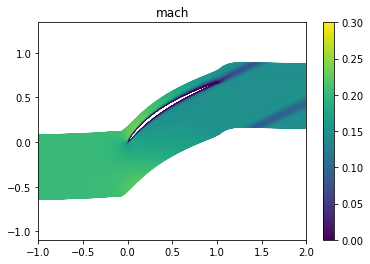

In [9]:
import numpy as np
from postpro.read_flo import *
from postpro.plot_flo import *

casename = 'notebook1'

# pop-out figure
#%matplotlib qt

%matplotlib inline


# read flow - prop and geom are dictionaries containing the flow and grid
prop,geom=read_flo(casename)

# plot_flo(prop,geom,plot_var,caxis)
plot_flo(prop,geom,'mach',[0.0,0.3])
#plot_flo(prop,geom,'p',[0.96e5,1.0e5])
#plot_flo(prop,geom,'mut_model',[0.0,50.0])
#plot_flo(prop,geom,'po',[0.99e5,1.001e5])
#plot_flo(prop,geom,'vortz',[-4000.0,4000.0])



Plot the loading

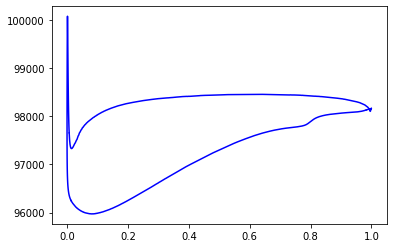

In [10]:
import matplotlib.pyplot as plt

wall_blocks = [3,4,5,7]

plt.figure(1)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],prop[i-1]['p'][:,-1,0],'b-')

plt.show()


### Plot the monitor file

Plot the monitor file to determine if the flow has converged or whether the case needs to be run for longer. Re-run the case if needed - if irestart=1, then the flow will be restarted from the previous solution and the monitor file will be appended.


In [12]:
from postpro.plot_monitor import *

casename = 'notebook1'

plot_monitor(casename);

### Check the mesh resolution

Once a steady flow has been established in RANS mode we can assess the mesh resolution.  The next cell determines the boundary layer properties and the near-wall cell sizes.


In [11]:
from postpro.boundarylayer import *

casename = 'notebook1'

bl =boundarylayer(casename);

Now plot the near-wall cell sizes

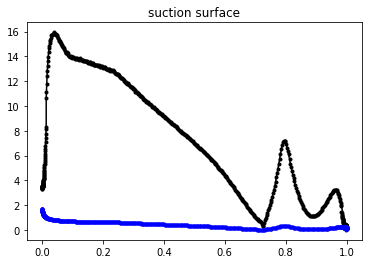

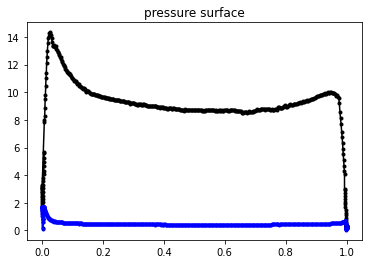

In [12]:
plt.figure(1)
plt.plot(bl['ss']['x'],bl['ss']['xplus'],'-k.')
plt.plot(bl['ss']['x'],bl['ss']['yplus'],'-b.')
plt.title('suction surface')
plt.show()


plt.figure(2)
plt.plot(bl['ps']['x'],bl['ps']['xplus'],'-k.')
plt.plot(bl['ps']['x'],bl['ps']['yplus'],'-b.')
plt.title('pressure surface')
plt.show()

This shows us that the wall normal resolution is probably ok (for now) but we need to increase the streamwise resolution quite significantly to ensure properly resolved results. For now, however, it's useful to work with an under resolved mesh and then refine once we are happy with the set-up. Later we will interpolate the flow onto a more refined mesh; running on a coarse mesh helps to establish a baseline flow.
***


## 1.5 Run an unsteady calculation
Now we can restart the solution and run for 100,000 iterations. First we need to modify the solver input file.


### Re-start from the preliminary steady RANS case

In [8]:
from meshing.read_case import *
from meshing.write_case import *
from meshing.write_rans import *

casename = 'notebook1'

# read case
case = read_case(casename)

# adjust iterations 
case['solver']['niter'] = 100000 # total number of iterations
case['solver']['irestart'] = 1 # restart the calculation with irestart=1

# write new case files
write_case(case)


# switch rans mode off
rans = {}
rans['if_rans'] = 0
rans['speed_up'] = 1.0

write_rans(casename,rans)



Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1


Now restart the simulation. You may wish to store the initial RANS solution in a separate folder for use later.

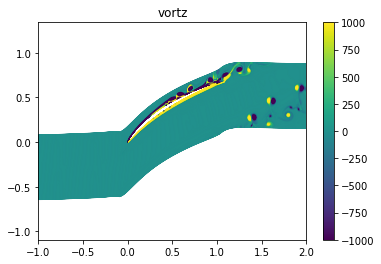

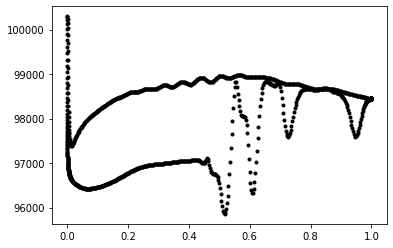

In [15]:
import numpy as np
from postpro.read_flo import *
from postpro.plot_flo import *

casename = 'notebook1'

# pop-out figure
#%matplotlib qt
%matplotlib inline


# read flow - prop and geom are dictionaries containing the flow and grid
prop,geom=read_flo(casename)

# plot the flow - plot_flo(prop,geom,plot_var,caxis)
#plot_flo(prop,geom,'mach',[0.0,0.3])
#plot_flo(prop,geom,'p',[0.96e5,1.0e5])
#plot_flo(prop,geom,'po',[1.0e5,1.002e5])
plot_flo(prop,geom,'vortz',[-1000,1000])

# plot the instantaneous loading
wall_blocks = [3,4,5,7]

plt.figure(2)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],prop[i-1]['p'][:,-1,0],'k.')

plt.show()

Running a time-accurate simulation without turbulence modelling allows the  natural instabilities in the flow to develop. Unsteadiness arises because of the strong vortex shedding from the trailing-edge and the formation of separation bubbles on the suction and pressure surfaces. In this case because of the low Reynolds number, a large separation bubble dominates the suction surface and this generates vortices which are shed from the separated shear layer. In a two-dimensional flow such as this there is no breakdown to turbulence and therefore unsteady structures and vortices persist and drive large perturbations in pressure. This can be seen by plotting the flow and surface pressure.

* Every time the solver writes out the flow files you can take another look at the flow.

* As the flow develops, notice how coherent 2D roll-ups form on the suction surface and in the trailing-edge vortex shedding. Because the flow is purely 2D, there can be no 3D turbulent breakdown. This means that unsteady structures are very intense and tend not to dissipate. You'll also notice how the vortices interact with each other, causing a very non-uniform flow at the exit. These flow features are largely a consequence of running in 2D- when we run in 3D with inflow turbulence these structures will be far less intense.

* Pressure waves are generated by the vortices on the blade surface and the trailing-edge - you can see these in the pressure contours. 

* Watch-out for when the starting vortex hits the exit boundary- this is a common cause for simulation failure, because the characteristic interfaces can fail when hit by such a strong pressure field.





### Create a movie of the flow

It is possible to generate a movie of the flow using spanwise cut files of the flow - the frequency these are written is determined by the value of 'ncut' in the input file. The cell below sets ncut=1000 so that kcut files are written every 1000 time steps. If you run the cell below, the input file will be updated. Re-start the simulation to gather the spanwise cut files.


In [16]:
from meshing.read_case import *
from meshing.write_case import *

casename = 'notebook1'

# read case
case = read_case(casename)

case['solver']['ncut'] = 10000 # write cut file frequency    
case['solver']['niter'] = 100000 # write cut file frequency    

# write new case files
write_case(case)


Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1



Once the simulation is complete, run the cell below to produce the snapshots of the flow from the 'kcut' files. The cell below creates an image of the flow for each spanwise cut file.


In [65]:
from postpro.read_kcuts import *

# create image files from the kcut files
read_kcuts(casename,[1000],'vortz',[-4000.0,4000.0]);



gpu input file found
2


You can compile these images now into a movie. One means to do this is to use ffmpeg. You can install ffmpeg here:

https://ffmpeg.org/download.html

Once ffmpeg is installed, use the following command in the notebook1 directory to create the movie file.

> ffmpeg -framerate 10 -pattern_type glob -i '*.png'   -c:v libx264 -pix_fmt yuv420p out.mp4

This creates a video from the image files, called out.mpeg. Read the ffmpeg documentation if you wish to adjust the video quality and frame rate.







In the next notebook you'll
* start running in 3D
* add inflow turbulence
* start gathering statistics

---

## Appendix - Running *3DNS-gpu* on other systems


If you don't want to use AWS, two other options are decribed below. However it is not possible to guarantee that this open version of *3DNS-gpu* will work on all systems. <b> If you wish to re-build *3DNS-gpu* to work on your own systems, you may need source access and a separate license agreement (e-mail aw329@cam.ac.uk for details on this). </b>


<u>Wilkes 3 cluster (A100 GPUs)</u>

Paid access to the Cambridge Wilkes3 GPU cluster:
https://www.hpc.cam.ac.uk/commercial-facilities


Access to the Cambridge Wilkes3 GPU cluster for University of Cambridge researchers:
https://www.hpc.cam.ac.uk/rcs-application


Once you have an account and are able to login to Wilkes3, you'll need to load the correct environment and use the appropiate version of *3DNS-gpu* (e-mail aw329@cam.ac.uk for the latest software and submission scripts in order to do this).   

<u>Using a local PC</u>

You may already have a PC or laptop with an NVIDIA GPU. In which case, you may be able to run  *3DNS-gpu*  using your local machine however you will probably need to use a Docker container to ensure you have the correct environment.

You can obtain a Docker container with the NVIDIA HPC SDK toolkit. You first need to install docker and then run the container:

* Install Docker 
https://docs.nvidia.com/ngc/gpu-cloud/ngc-catalog-user-guide/index.html#access-container-via-ngc-cli


* Run the NVIDIA HPC SDK container
https://docs.nvidia.com/hpc-sdk/hpc-sdk-container/index.html


Make sure to check that your system satisifies the minimum hardware requirements for running the NVIDIA HPC SDK container before embarking on this option. 

The provided open *3DNS-gpu* executibles are built for AMD/Intel x86-64 architectures. 

<b> Please note that it is not possible to guarantee *3DNS-gpu* will run on all platforms. </b>
